# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

from sklearn.metrics import (
    mean_absolute_error, mean_absolute_percentage_error,
    root_mean_squared_error
)

%matplotlib inline

In [2]:
air_data = pd.read_csv('/Users/asliozdemirstrollo/Documents/Documents/Time Series/Clean Skies London/air-quality-london-monthly-averages.csv')

# Limiting to desired information
target: str = 'London Mean Roadside:Nitrogen Dioxide (ug/m3)'
air_data: pd.DataFrame = air_data[['Month', target]]

# Cleaning

In [3]:
# Converting to datetime, using format to interpret format
air_data['Month'] = pd.to_datetime(air_data['Month'], format='%b-%y')

# Can't have duplicate dates, aggregating all rows with the same date
no2_df: pd.DataFrame = (
    air_data
    .resample('MS', on='Month') # Aggregating daily
    .agg(y=(target, 'mean')) # Getting the average no2 and naming it y for prophet
    .reset_index() # Making Month a column again after the agg
    .rename(columns={'Month':'ds'}) # Renaming to prophet format
)
no2_df

,ds,y
0,2008-01-01,55.5
1,2008-02-01,75.9
2,2008-03-01,55.6
3,2008-04-01,61.8
4,2008-05-01,62.9
...,...,...
135,2019-04-01,46.2
136,2019-05-01,39.7
137,2019-06-01,34.9
138,2019-07-01,NaN


We could interpolate missing values, but it's generally safer to let Prophet simply ignore them. 

In [4]:
no2_df.dropna(inplace=True)

## Train Test Split

Determining split index by desired training data proportion

In [5]:
# Calculating split location
total_months = len(no2_df)
train_size = 0.9
idx_split = int(total_months * train_size)

# Separating training months from testing months
train_df: pd.DataFrame = no2_df.iloc[:idx_split]
test_df: pd.DataFrame = no2_df.iloc[idx_split:]

# Modeling

In [6]:
# Initializing model 
model = Prophet()

# Fitting to training data
# Prophet requires that you do this before cross-validation even though the
# model will be refit, this is where we provide it with the training data
model.fit(train_df)

12:39:28 - cmdstanpy - INFO - Chain [1] start processing
12:39:28 - cmdstanpy - INFO - Chain [1] done processing


### Cross-Validation

`cross_validation` and `performance metrics` don't work very cleanly with monthly data. Prophet assumes the data is on a daily frequency so the splits for cross validation have to be a number of days instead of a number of months. This becomes a problem since different months are different numbers of days. There is no easy fix to this although there are some hacks to make the problem less severe. 

One problem comes from the `period` parameter in the `cross_validation` function. Our labeled data is very sparse for Prophet, which is expecting a daily frequency. When we push the training window forwards a number of days, we add an inconsistent number of new data points to the training set, and test against each data point an inconsistent number of times. To mitigate this issue, we can create a custom set of "cutoffs". These cutoffs are dates where the data is split into training and testing. We can place these strategically at a monthly frequency. 

This does not completely solve the problem however, because we cannot provide a custom list for the horizons, `cross_validate` will always predict ahead the same number of days. 92 will ensure that we always get 3 labeled data points within the horizon. 

In [7]:
# 3 years of training data minimum
initial: pd.Timestamp = train_df['ds'].min() + pd.DateOffset(years=3)

# Last fold must have room for horizon (92 days)
horizon: int = 92
last_cutoff: pd.Timestamp = train_df['ds'].max() - pd.DateOffset(days=horizon)

# Manually defining cutoffs for monthly frequency
cutoffs: pd.DatetimeIndex = pd.date_range(start=initial, end=last_cutoff, freq='MS') #MS = start of each month

df_cv: pd.DataFrame = cross_validation(
    model,
    cutoffs=cutoffs,
    horizon=f'{horizon} days'
)

  0%|          | 0/85 [00:00<?, ?it/s]

12:39:31 - cmdstanpy - INFO - Chain [1] start processing
12:39:31 - cmdstanpy - INFO - Chain [1] done processing
12:39:31 - cmdstanpy - INFO - Chain [1] start processing
12:39:31 - cmdstanpy - INFO - Chain [1] done processing
12:39:31 - cmdstanpy - INFO - Chain [1] start processing
12:39:31 - cmdstanpy - INFO - Chain [1] done processing
12:39:31 - cmdstanpy - INFO - Chain [1] start processing
12:39:31 - cmdstanpy - INFO - Chain [1] done processing
12:39:31 - cmdstanpy - INFO - Chain [1] start processing
12:39:32 - cmdstanpy - INFO - Chain [1] done processing
12:39:32 - cmdstanpy - INFO - Chain [1] start processing
12:39:32 - cmdstanpy - INFO - Chain [1] done processing
12:39:32 - cmdstanpy - INFO - Chain [1] start processing
12:39:32 - cmdstanpy - INFO - Chain [1] done processing
12:39:32 - cmdstanpy - INFO - Chain [1] start processing
12:39:32 - cmdstanpy - INFO - Chain [1] done processing
12:39:32 - cmdstanpy - INFO - Chain [1] start processing
12:39:32 - cmdstanpy - INFO - Chain [1]

#### Examining averaged predictions

We can average the predictions for each date across folds and plot the predictions. This is aggregating cases where the data is being predicted 1, 2, and 3 months in advance. 

In [8]:
df_cv.groupby('ds').mean()[['yhat', 'y']].plot();

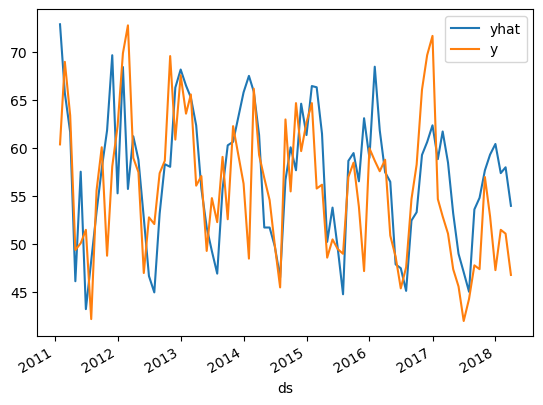

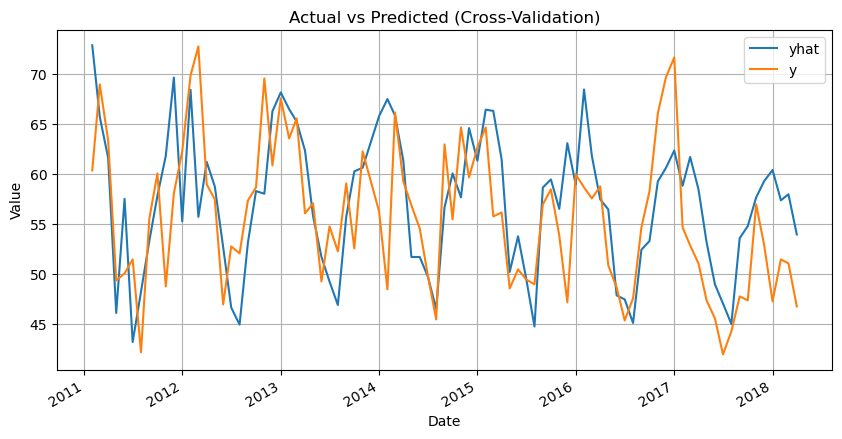

In [9]:
# --- Add this near the top of your notebook once ---
%matplotlib inline
import matplotlib.pyplot as plt

# --- Your Prophet cross-validation code ---
# (assuming df_cv already exists)
ax = df_cv.groupby('ds').mean()[['yhat', 'y']].plot(figsize=(10,5))
plt.title("Actual vs Predicted (Cross-Validation)")
plt.xlabel("Date")
plt.ylabel("Value")
plt.grid(True)

# --- Force display ---
plt.show()

To get a sense of how well the model can forecast further in advance, we can look at how the model does with just it's 3-months-in-advance predictions by filtering down to those scores

In [10]:
# Calculate horizon as difference between training cutoff and month being predicted
df_cv['horizon'] = df_cv['ds'] - df_cv['cutoff']
# Filter to horizons over 70 days (ensures only 3-month preds left)
df_cv_3_months: pd.DataFrame = df_cv.loc[df_cv['horizon'] > pd.Timedelta(days=70)]

df_cv_3_months.groupby('ds').mean()[['yhat', 'y']].plot();

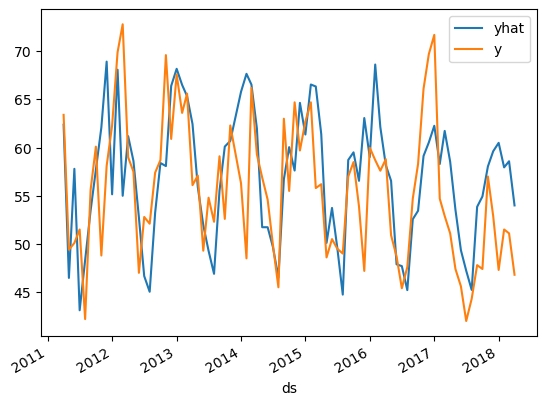

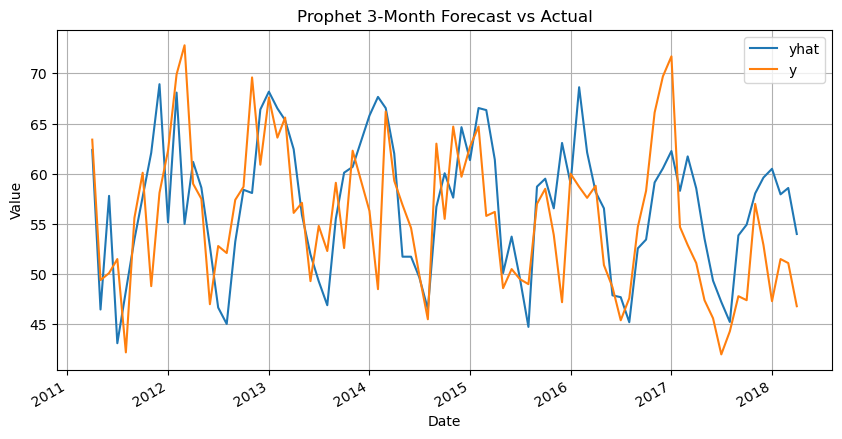

In [11]:
# --- At the top of your notebook (run once) ---
%matplotlib inline
import matplotlib.pyplot as plt

# --- Your existing code ---
df_cv['horizon'] = df_cv['ds'] - df_cv['cutoff']
df_cv_3_months = df_cv.loc[df_cv['horizon'] > pd.Timedelta(days=70)]

# --- Plot (and force display) ---
ax = df_cv_3_months.groupby('ds').mean()[['yhat', 'y']].plot(figsize=(10, 5))
plt.title("Prophet 3-Month Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Value")
plt.grid(True)

# --- Crucial line: forces the plot to appear ---
plt.show()

#### Examining performance metrics

We can use the `performance_metrics` function but we'll run into a problem with it. `performance_metrics` aggregates by horizon, but since our months are inconsistent lengths, it won't aggregate all the 1-month horizons together, it will aggregate 28, 29, 30, and 31 days separately. 

We should also be careful to set `rolling_window=0` or we will get some undesired behavior. With a non-zero rolling window the function with "smear" the performance to get scores for horizons like 10 days for which we have no real data.

In [12]:
df_perf: pd.DataFrame = performance_metrics(df_cv, rolling_window=0)
df_perf

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,28 days,40.740632,6.382839,4.871016,0.085913,0.048585,0.080292,0.600000
1,29 days,143.877460,11.994893,10.072147,0.144803,0.144803,0.158522,0.500000
2,30 days,38.361855,6.193695,4.971557,0.093609,0.086058,0.090434,0.629630
3,31 days,39.339251,6.272101,4.897142,0.089627,0.070892,0.086346,0.600000
4,59 days,33.421969,5.781174,4.701301,0.085403,0.091358,0.080375,0.545455
5,60 days,77.598415,8.808996,6.342149,0.094549,0.060264,0.101137,0.750000
6,61 days,37.714684,6.141228,4.915427,0.091865,0.088435,0.089574,0.581818
7,62 days,46.505705,6.819509,5.143010,0.094808,0.064502,0.088742,0.714286
8,89 days,15.350835,3.918014,3.390880,0.066376,0.059266,0.065972,0.800000
9,90 days,35.489809,5.957332,4.933729,0.092976,0.111075,0.087046,0.461538


We can see that we have a fundamental problem using Prophet with monthly data because 28, 29, 30, and 31 days are all aggregated separately as different horizons even though they all correspond with "1 month". We cannot simply bin and average them either because rare horizons like 29 days would get more sway over that average than they deserve. 

We can do some manual aggregations with the cross-validation results instead

In [13]:
# Convert from nanosecond timedeltas into days
df_cv['horizon_days'] = df_cv['horizon'].dt.days

# Binning months
df_cv['horizon_months'] = df_cv['horizon_days'] / 30.5
df_cv['horizon_months'] = df_cv['horizon_months'].round().astype(int)

# Manually calculating performance metric (absolute error)
df_cv['absolute_error'] = abs(df_cv['y'] - df_cv['yhat'])

# Scatter plot for daily (line would be misleading since most days have no data)
sns.relplot(
    df_cv,
    kind='scatter',
    x='horizon_days',
    y='absolute_error',
    alpha=0.3
)
# Line plot with monthly error. 
# Seaborn automatically computes the mean and standard deviation
sns.relplot(
    df_cv,
    kind='line',
    x='horizon_months',
    y='absolute_error'
);

In [14]:
# --- Run once near the top of the notebook ---
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: nicer defaults
sns.set_theme()

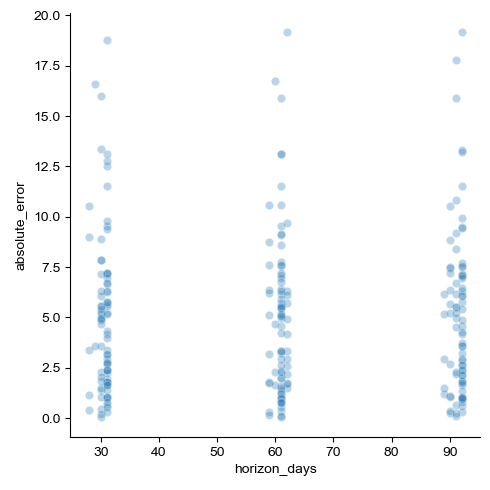

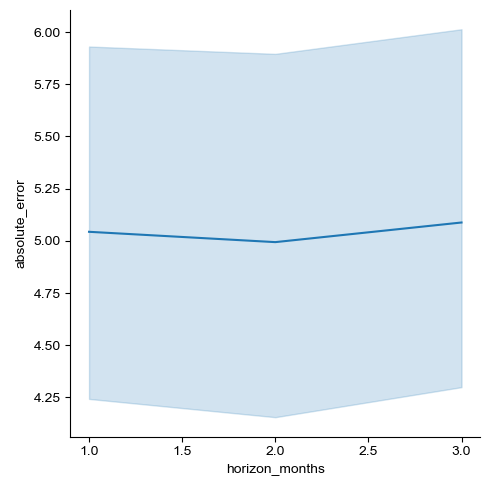

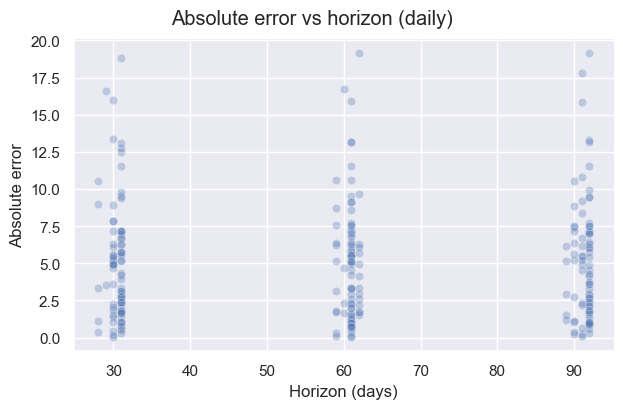

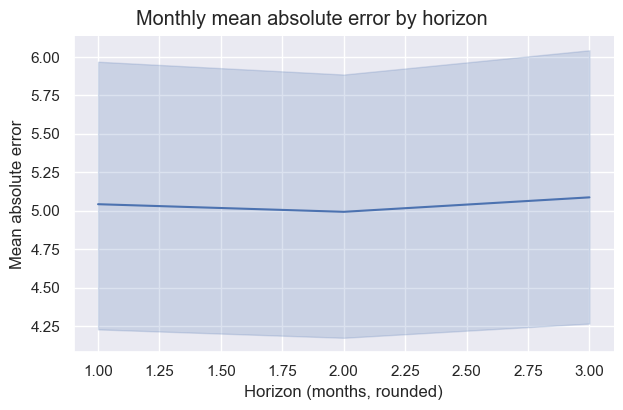

In [15]:
# --- Your prep code (unchanged) ---
df_cv['horizon_days'] = df_cv['horizon'].dt.days
df_cv['horizon_months'] = (df_cv['horizon_days'] / 30.5).round().astype(int)
df_cv['absolute_error'] = (df_cv['y'] - df_cv['yhat']).abs()

# --- Scatter: daily absolute error vs horizon (days) ---
g1 = sns.relplot(
    data=df_cv,
    kind='scatter',
    x='horizon_days',
    y='absolute_error',
    alpha=0.3,
    height=4,
    aspect=1.6
)
g1.set_axis_labels("Horizon (days)", "Absolute error")
g1.figure.suptitle("Absolute error vs horizon (daily)", y=1.02)
plt.show()  # <-- force render

# --- Line: monthly mean absolute error vs horizon (months) ---
g2 = sns.relplot(
    data=df_cv,
    kind='line',
    x='horizon_months',
    y='absolute_error',
    errorbar=('ci', 95),  # mean ± 95% CI
    height=4,
    aspect=1.6
)
g2.set_axis_labels("Horizon (months, rounded)", "Mean absolute error")
g2.figure.suptitle("Monthly mean absolute error by horizon", y=1.02)
plt.show()  # <-- force render

It looks like our error was relatively stable with larger horizons. If we tried even larger numbers we should see it increase the further into the future your model is trying to predict.

We can summarize the model's performance with a chosen horizon, we'll go with the full three months

In [16]:
mae_3m = df_cv.loc[df_cv['horizon_months']==3, 'absolute_error'].mean()
print(f'3 Month Horizon MAE (averaged across folds): {mae_3m}')

3 Month Horizon MAE (averaged across folds): 5.087247043342641


## Tuning Hyperparameters

To find optimal values for the regularization hyperparameters `change_point_prior_scale` and `seasonality_prior_scale` we can use cross-validation to tune them with less risk of overfitting. 

In [17]:
# Defining parameter grid
param_grid: dict[str, list[float]] = {
    'changepoint_prior_scale': [0.1, 1.0],
    'seasonality_prior_scale': [0.01, 0.1, 1.0]
}

# Building the list of all parameter combinations to make tuning loop simpler
all_params: list[dict[str, float]] = []
for cps in param_grid['changepoint_prior_scale']:
    for sps in param_grid['seasonality_prior_scale']:
        all_params.append({
            'changepoint_prior_scale': cps,
            'seasonality_prior_scale': sps
        })


# --- Tuning Loop ---
results: list[dict[str, float]] = []
for params in all_params:

    # Initializing with hyperparameters
    model = Prophet(**params)
    # Fitting to training data
    model.fit(train_df)

    # --- Setting up cross-validation ---
    # 3 years of training data minimum
    initial: pd.Timestamp = train_df['ds'].min() + pd.DateOffset(years=3)
    # Last fold must have room for horizon (3 months)
    last_cutoff: pd.Timestamp = train_df['ds'].max() - pd.DateOffset(days=horizon)
    # Manually defining cutoffs for monthly frequency
    cutoffs: pd.DatetimeIndex = pd.date_range(start=initial, end=last_cutoff, freq='MS') #MS = start of each month

    # Performing cross-validation
    df_cv: pd.DataFrame = cross_validation(
        model,
        cutoffs=cutoffs,
        horizon=f'{horizon} days'
    )

    # Compute errors
    df_cv['error'] = df_cv['y'] - df_cv['yhat']
    df_cv['absolute_error'] = abs(df_cv['error'])
    df_cv['squared_error'] = (df_cv['error'])**2
    df_cv['percentage_error'] = df_cv['absolute_error'] / df_cv['y']

    # Aggregate errors
    df_cv_means = df_cv.mean()
    
    # Store scores for hyperparameters
    results.append({
        'changepoint_prior_scale': params['changepoint_prior_scale'],
        'seasonality_prior_scale': params['seasonality_prior_scale'],
        'MAE': df_cv_means['absolute_error'],
        'RMSE': (df_cv_means['squared_error']**0.5),
        'MAPE': df_cv_means['percentage_error'],
    })

# Convert list of dicts to data frame
results_df = pd.DataFrame(results)
results_df

12:40:00 - cmdstanpy - INFO - Chain [1] start processing
12:40:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/85 [00:00<?, ?it/s]

12:40:00 - cmdstanpy - INFO - Chain [1] start processing
12:40:01 - cmdstanpy - INFO - Chain [1] done processing
12:40:01 - cmdstanpy - INFO - Chain [1] start processing
12:40:01 - cmdstanpy - INFO - Chain [1] done processing
12:40:01 - cmdstanpy - INFO - Chain [1] start processing
12:40:01 - cmdstanpy - INFO - Chain [1] done processing
12:40:01 - cmdstanpy - INFO - Chain [1] start processing
12:40:01 - cmdstanpy - INFO - Chain [1] done processing
12:40:01 - cmdstanpy - INFO - Chain [1] start processing
12:40:01 - cmdstanpy - INFO - Chain [1] done processing
12:40:01 - cmdstanpy - INFO - Chain [1] start processing
12:40:01 - cmdstanpy - INFO - Chain [1] done processing
12:40:01 - cmdstanpy - INFO - Chain [1] start processing
12:40:01 - cmdstanpy - INFO - Chain [1] done processing
12:40:01 - cmdstanpy - INFO - Chain [1] start processing
12:40:01 - cmdstanpy - INFO - Chain [1] done processing
12:40:01 - cmdstanpy - INFO - Chain [1] start processing
12:40:01 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/85 [00:00<?, ?it/s]

12:40:09 - cmdstanpy - INFO - Chain [1] start processing
12:40:09 - cmdstanpy - INFO - Chain [1] done processing
12:40:09 - cmdstanpy - INFO - Chain [1] start processing
12:40:09 - cmdstanpy - INFO - Chain [1] done processing
12:40:09 - cmdstanpy - INFO - Chain [1] start processing
12:40:09 - cmdstanpy - INFO - Chain [1] done processing
12:40:09 - cmdstanpy - INFO - Chain [1] start processing
12:40:09 - cmdstanpy - INFO - Chain [1] done processing
12:40:09 - cmdstanpy - INFO - Chain [1] start processing
12:40:09 - cmdstanpy - INFO - Chain [1] done processing
12:40:09 - cmdstanpy - INFO - Chain [1] start processing
12:40:09 - cmdstanpy - INFO - Chain [1] done processing
12:40:09 - cmdstanpy - INFO - Chain [1] start processing
12:40:09 - cmdstanpy - INFO - Chain [1] done processing
12:40:09 - cmdstanpy - INFO - Chain [1] start processing
12:40:09 - cmdstanpy - INFO - Chain [1] done processing
12:40:09 - cmdstanpy - INFO - Chain [1] start processing
12:40:09 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/85 [00:00<?, ?it/s]

12:40:18 - cmdstanpy - INFO - Chain [1] start processing
12:40:18 - cmdstanpy - INFO - Chain [1] done processing
12:40:18 - cmdstanpy - INFO - Chain [1] start processing
12:40:18 - cmdstanpy - INFO - Chain [1] done processing
12:40:18 - cmdstanpy - INFO - Chain [1] start processing
12:40:18 - cmdstanpy - INFO - Chain [1] done processing
12:40:18 - cmdstanpy - INFO - Chain [1] start processing
12:40:18 - cmdstanpy - INFO - Chain [1] done processing
12:40:18 - cmdstanpy - INFO - Chain [1] start processing
12:40:18 - cmdstanpy - INFO - Chain [1] done processing
12:40:18 - cmdstanpy - INFO - Chain [1] start processing
12:40:18 - cmdstanpy - INFO - Chain [1] done processing
12:40:18 - cmdstanpy - INFO - Chain [1] start processing
12:40:18 - cmdstanpy - INFO - Chain [1] done processing
12:40:18 - cmdstanpy - INFO - Chain [1] start processing
12:40:18 - cmdstanpy - INFO - Chain [1] done processing
12:40:18 - cmdstanpy - INFO - Chain [1] start processing
12:40:19 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/85 [00:00<?, ?it/s]

12:40:27 - cmdstanpy - INFO - Chain [1] start processing
12:40:27 - cmdstanpy - INFO - Chain [1] done processing
12:40:27 - cmdstanpy - INFO - Chain [1] start processing
12:40:27 - cmdstanpy - INFO - Chain [1] done processing
12:40:27 - cmdstanpy - INFO - Chain [1] start processing
12:40:27 - cmdstanpy - INFO - Chain [1] done processing
12:40:27 - cmdstanpy - INFO - Chain [1] start processing
12:40:27 - cmdstanpy - INFO - Chain [1] done processing
12:40:27 - cmdstanpy - INFO - Chain [1] start processing
12:40:28 - cmdstanpy - INFO - Chain [1] done processing
12:40:28 - cmdstanpy - INFO - Chain [1] start processing
12:40:28 - cmdstanpy - INFO - Chain [1] done processing
12:40:28 - cmdstanpy - INFO - Chain [1] start processing
12:40:28 - cmdstanpy - INFO - Chain [1] done processing
12:40:28 - cmdstanpy - INFO - Chain [1] start processing
12:40:28 - cmdstanpy - INFO - Chain [1] done processing
12:40:28 - cmdstanpy - INFO - Chain [1] start processing
12:40:28 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/85 [00:00<?, ?it/s]

12:40:40 - cmdstanpy - INFO - Chain [1] start processing
12:40:40 - cmdstanpy - INFO - Chain [1] done processing
12:40:40 - cmdstanpy - INFO - Chain [1] start processing
12:40:40 - cmdstanpy - INFO - Chain [1] done processing
12:40:40 - cmdstanpy - INFO - Chain [1] start processing
12:40:41 - cmdstanpy - INFO - Chain [1] done processing
12:40:41 - cmdstanpy - INFO - Chain [1] start processing
12:40:41 - cmdstanpy - INFO - Chain [1] done processing
12:40:41 - cmdstanpy - INFO - Chain [1] start processing
12:40:41 - cmdstanpy - INFO - Chain [1] done processing
12:40:41 - cmdstanpy - INFO - Chain [1] start processing
12:40:41 - cmdstanpy - INFO - Chain [1] done processing
12:40:41 - cmdstanpy - INFO - Chain [1] start processing
12:40:41 - cmdstanpy - INFO - Chain [1] done processing
12:40:41 - cmdstanpy - INFO - Chain [1] start processing
12:40:42 - cmdstanpy - INFO - Chain [1] done processing
12:40:42 - cmdstanpy - INFO - Chain [1] start processing
12:40:42 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/85 [00:00<?, ?it/s]

12:40:54 - cmdstanpy - INFO - Chain [1] start processing
12:40:54 - cmdstanpy - INFO - Chain [1] done processing
12:40:54 - cmdstanpy - INFO - Chain [1] start processing
12:40:54 - cmdstanpy - INFO - Chain [1] done processing
12:40:54 - cmdstanpy - INFO - Chain [1] start processing
12:40:54 - cmdstanpy - INFO - Chain [1] done processing
12:40:54 - cmdstanpy - INFO - Chain [1] start processing
12:40:55 - cmdstanpy - INFO - Chain [1] done processing
12:40:55 - cmdstanpy - INFO - Chain [1] start processing
12:40:55 - cmdstanpy - INFO - Chain [1] done processing
12:40:55 - cmdstanpy - INFO - Chain [1] start processing
12:40:55 - cmdstanpy - INFO - Chain [1] done processing
12:40:55 - cmdstanpy - INFO - Chain [1] start processing
12:40:55 - cmdstanpy - INFO - Chain [1] done processing
12:40:55 - cmdstanpy - INFO - Chain [1] start processing
12:40:56 - cmdstanpy - INFO - Chain [1] done processing
12:40:56 - cmdstanpy - INFO - Chain [1] start processing
12:40:56 - cmdstanpy - INFO - Chain [1]

,changepoint_prior_scale,seasonality_prior_scale,MAE,RMSE,MAPE
0,0.1,0.01,4.913603,6.280940,0.090415
1,0.1,0.10,4.687193,6.044438,0.085561
2,0.1,1.00,4.950981,6.378915,0.090438
3,1.0,0.01,5.990968,7.746045,0.108515
4,1.0,0.10,5.288258,6.518775,0.095463
5,1.0,1.00,5.652041,7.024280,0.102076


In [18]:
results_df.sort_values('MAE')

,changepoint_prior_scale,seasonality_prior_scale,MAE,RMSE,MAPE
1,0.1,0.10,4.687193,6.044438,0.085561
0,0.1,0.01,4.913603,6.280940,0.090415
2,0.1,1.00,4.950981,6.378915,0.090438
4,1.0,0.10,5.288258,6.518775,0.095463
5,1.0,1.00,5.652041,7.024280,0.102076
3,1.0,0.01,5.990968,7.746045,0.108515


## Evaluate on Testing Data

In [19]:
# Setting up scoring

def score_model(
    y_true : pd.Series, 
    y_pred : pd.Series,
) -> dict[str, float]:
    "Compute various scores and return dict"
    
    scores = {
        'MAE': mean_absolute_error(y_true, y_pred),
        'MAPE': mean_absolute_percentage_error(y_true, y_pred),
        'RMSE': root_mean_squared_error(y_true, y_pred)
    }
    return scores

# Setting up scoreboard
scoreboard = pd.DataFrame(columns=['Model', 'MAE', 'MAPE', 'RMSE']).set_index('Model')

In [20]:
# Extract optimal hyperparameters
params = param_grid.keys()
best_params = results_df.loc[results_df['MAE'].idxmin(), params].to_dict()

# Initialize with the optimal hyperparameters
model = Prophet(**best_params)

# Fitting to training data
model.fit(train_df)

# Forecasting testing window
test_forecast: pd.DataFrame = model.predict(test_df)

# Score 
scoreboard.loc['Tuned Model', :] = score_model(test_df['y'], test_forecast['yhat'])
scoreboard

12:41:09 - cmdstanpy - INFO - Chain [1] start processing
12:41:09 - cmdstanpy - INFO - Chain [1] done processing


,MAE,MAPE,RMSE
Model,,,
Tuned Model,3.978971,0.092966,4.708413


### Plotting

In [21]:

model = Prophet (**best_params)
model.fit(no2_df)

future = model.make_future_dataframe(36,freq ='MS')

forecast: pd.DataFrame = model.predict(future)



/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


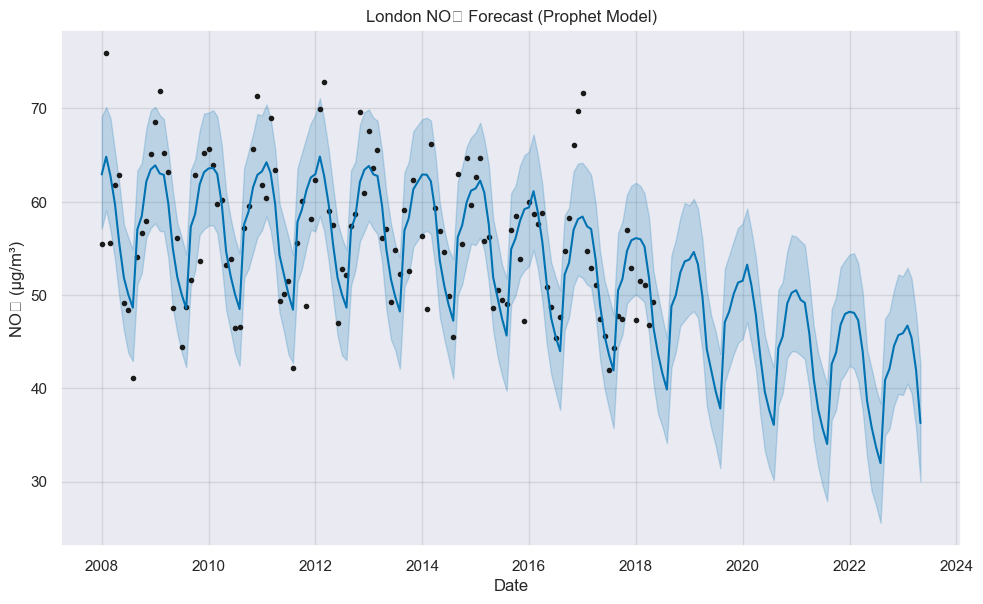

In [32]:
# Extend further (5 years ahead)
future = model.make_future_dataframe(periods=60, freq='MS')  # 5 years = 60 months
forecast = model.predict(future)

fig = model.plot(forecast)
plt.title("London NO₂ Forecast (Prophet Model)")
plt.xlabel("Date")
plt.ylabel("NO₂ (µg/m³)")
plt.grid(True)
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


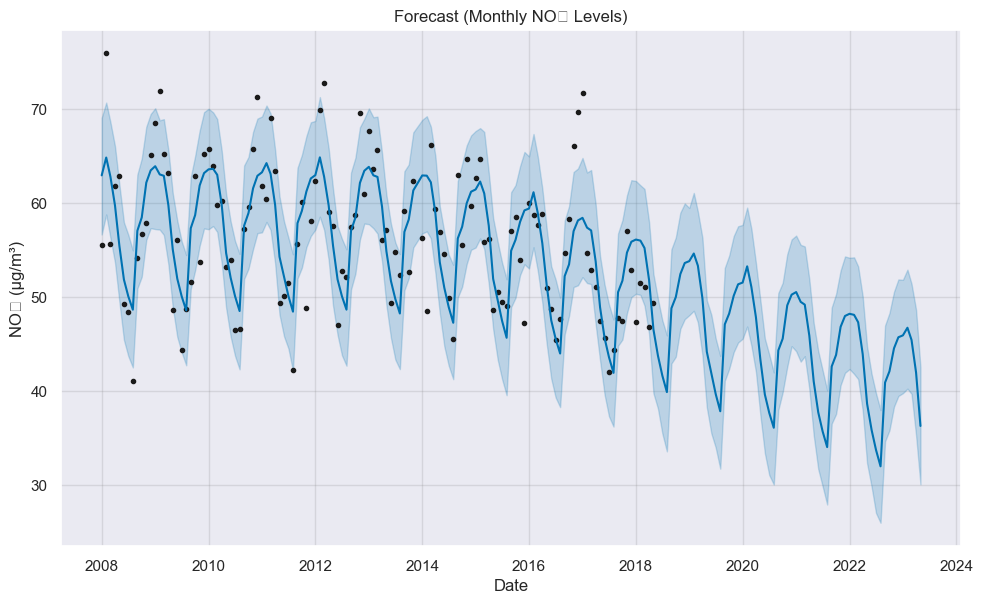

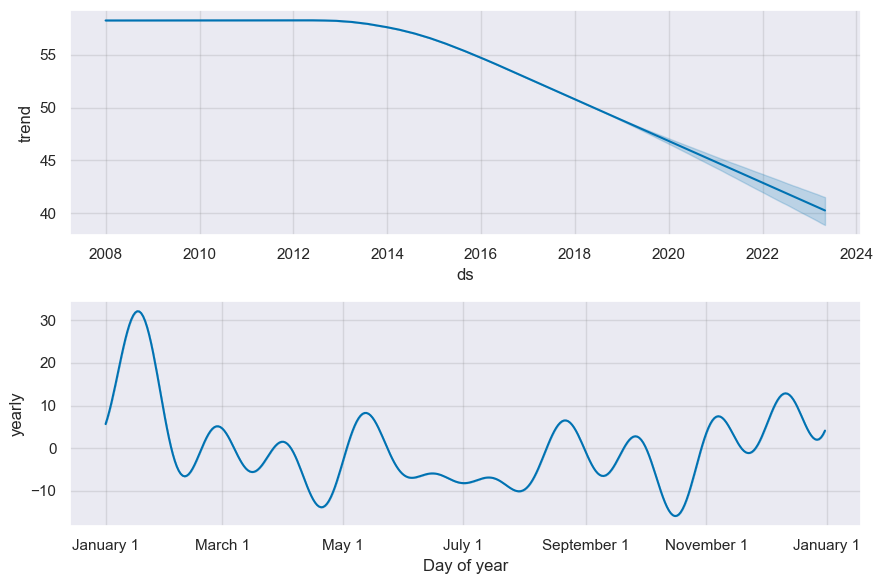

In [33]:
# --- 8) Make future monthly forecast ---
future = model.make_future_dataframe(periods=60, freq='MS')  # predict 3 years ahead (monthly)
forecast = model.predict(future)

# --- Plot forecast ---
fig1 = model.plot(forecast)
plt.title("Forecast (Monthly NO₂ Levels)")
plt.xlabel("Date")
plt.ylabel("NO₂ (µg/m³)")
plt.grid(True)
plt.show()

# --- Plot trend + seasonality components ---
fig2 = model.plot_components(forecast)
plt.show()

/var/folders/xn/tw0sz0nx6dv2wmn3xgpg0s0r0000gn/T/ipykernel_1093/3836660876.py:31: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout(); plt.show()
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


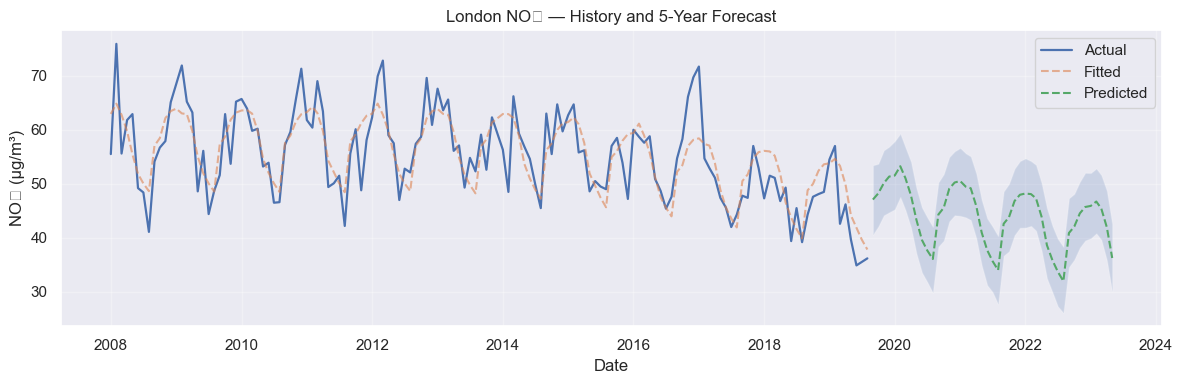

In [34]:
import matplotlib.pyplot as plt

# 1) Forecast further out
future = model.make_future_dataframe(periods=60, freq='MS')  # 5 years ahead
forecast = model.predict(future)

# 2) Split fitted vs future part
last_obs = no2_df['ds'].max()
fitted = forecast[forecast['ds'] <= last_obs]      # in-sample fit
future_fc = forecast[forecast['ds'] >  last_obs]   # out-of-sample forecast

# 3) Plot
fig, ax = plt.subplots(figsize=(12,4))

# Actuals
ax.plot(no2_df['ds'], no2_df['y'], label='Actual', linewidth=1.6)

# Fitted (optional, light dashed)
ax.plot(fitted['ds'], fitted['yhat'], linestyle='--', alpha=0.6, label='Fitted')

# Forecast (orange dashed) + uncertainty band
ax.plot(future_fc['ds'], future_fc['yhat'], linestyle='--', label='Predicted')
ax.fill_between(future_fc['ds'],
                future_fc['yhat_lower'],
                future_fc['yhat_upper'],
                alpha=0.2)

ax.set_title('London NO₂ — History and 5-Year Forecast')
ax.set_xlabel('Date'); ax.set_ylabel('NO₂ (µg/m³)')
ax.grid(True, alpha=0.3); ax.legend()
plt.tight_layout(); plt.show()

/var/folders/xn/tw0sz0nx6dv2wmn3xgpg0s0r0000gn/T/ipykernel_1093/1774265807.py:28: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout(); plt.show()
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


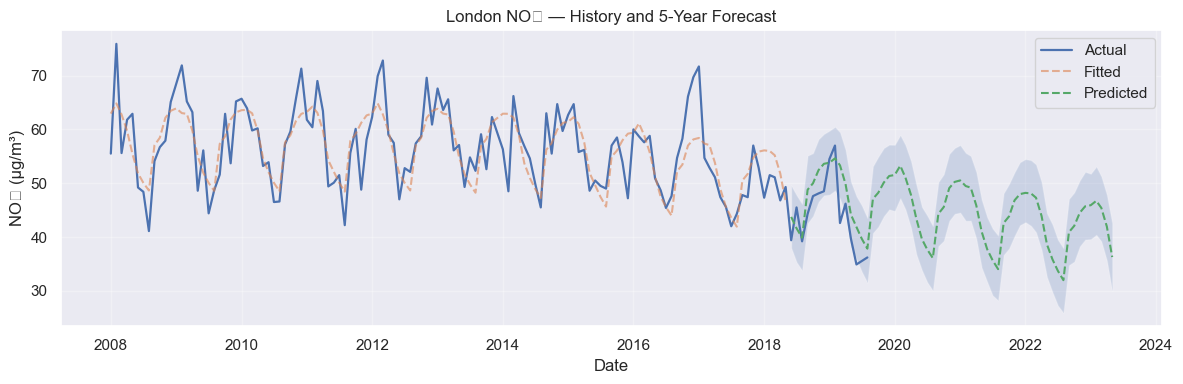

In [35]:
import matplotlib.pyplot as plt

# 1) Forecast further out with the model trained on train_df
future   = model.make_future_dataframe(periods=60, freq='MS')  # 5 years ahead
forecast = model.predict(future)

# 2) Split at the *end of training data* (this was the gap culprit)
last_train = train_df['ds'].max()
fitted     = forecast[forecast['ds'] <= last_train]     # in-sample fit
future_fc  = forecast[forecast['ds'] >  last_train]     # out-of-sample forecast

# 3) Plot
fig, ax = plt.subplots(figsize=(12,4))

# Actuals (train + test)
ax.plot(no2_df['ds'], no2_df['y'], label='Actual', linewidth=1.6)

# Fitted on train period (optional)
ax.plot(fitted['ds'], fitted['yhat'], linestyle='--', alpha=0.6, label='Fitted')

# Forecast + uncertainty
ax.plot(future_fc['ds'], future_fc['yhat'], linestyle='--', label='Predicted')
ax.fill_between(future_fc['ds'], future_fc['yhat_lower'], future_fc['yhat_upper'], alpha=0.2)

ax.set_title('London NO₂ — History and 5-Year Forecast')
ax.set_xlabel('Date'); ax.set_ylabel('NO₂ (µg/m³)')
ax.grid(True, alpha=0.3); ax.legend()
plt.tight_layout(); plt.show()

#### --- 8) Make future monthly forecast ---
future = model.make_future_dataframe(periods=36, freq='MS')  # predict 3 years ahead (monthly)
forecast = model.predict(future)

# --- Plot forecast ---
fig1 = model.plot(forecast)
plt.title("Forecast (Monthly NO₂ Levels)")
plt.xlabel("Date")
plt.ylabel("NO₂ (µg/m³)")
plt.grid(True)
plt.show()

# --- Plot trend + seasonality components ---
fig2 = model.plot_components(forecast)
plt.show()

#### Plotting forecast with built in plotting function
model.plot(forecast);

In [23]:
# Plotting trend and seasonal components
model.plot_components(forecast);

We'll have to use custom plots to be able to zoom into the prediction region

In [24]:
# Gathering plot info into data frame
plot_df = no2_df[['ds', 'y']].rename(columns={'y': 'Actual'}).set_index('ds')
plot_df['Prediction'] = forecast.set_index('ds')['yhat'] #common index will be aligned

# Plotting
g_full = sns.relplot(
    plot_df,
    kind='line',
    aspect=2
)
g_zoomed = sns.relplot(
    plot_df.iloc[idx_split:],
    kind='line',
    aspect=2
)

# Getting axes for shading confidence regions
ax_full = g_full.ax 
ax_zoomed = g_zoomed.ax 

# Fill confidence regions
for ax, forecasted in [(ax_full, forecast), (ax_zoomed, forecast.iloc[idx_split:])]:
    ax.fill_between(
        forecasted['ds'],           # Dates of prediction region
        forecasted['yhat_lower'],   # Lower confidence bound
        forecasted['yhat_upper'],   # Upper confidence bound
        color='orange', 
        alpha=0.2,
        label='Confidence Interval'
    );

This is the best forecast we've seen so far, clearly tuning these hyperparameters with cross-validation had a positive effect. We can also see how by lowering the priors (thus increasing regularization strength) resulted in a smoother model. Reducing the spikeyness of the model like this generally reduces overfitting.

In [25]:
# Run once near the top of the notebook
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

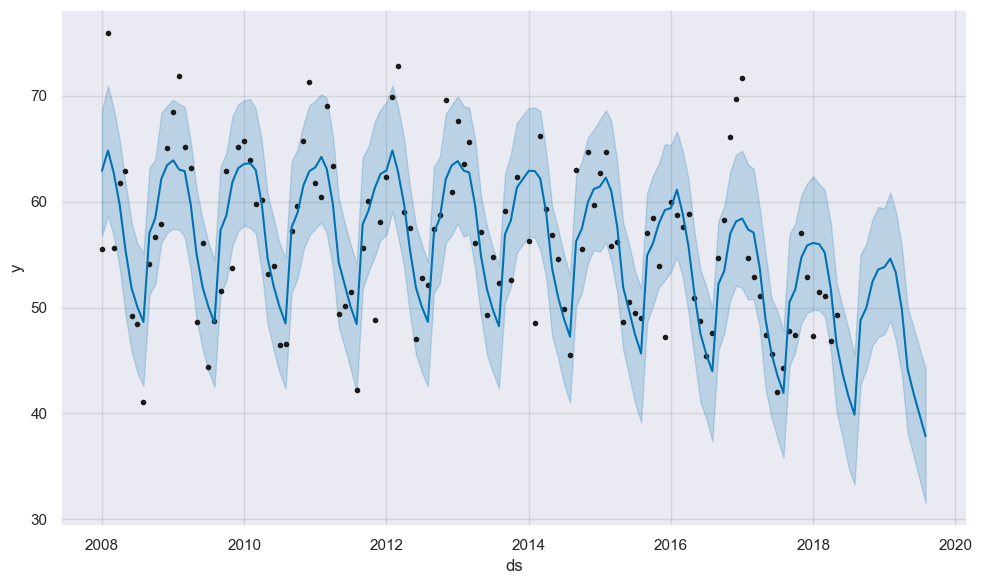

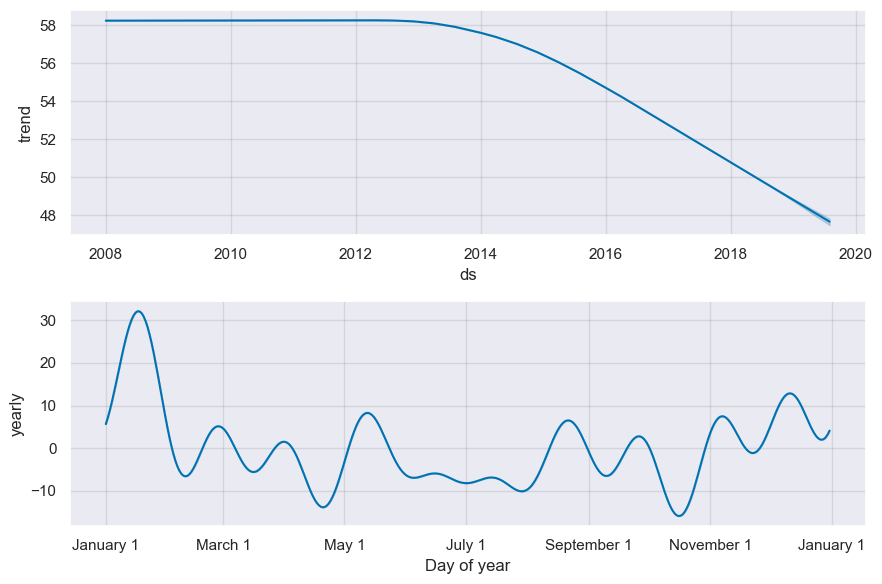

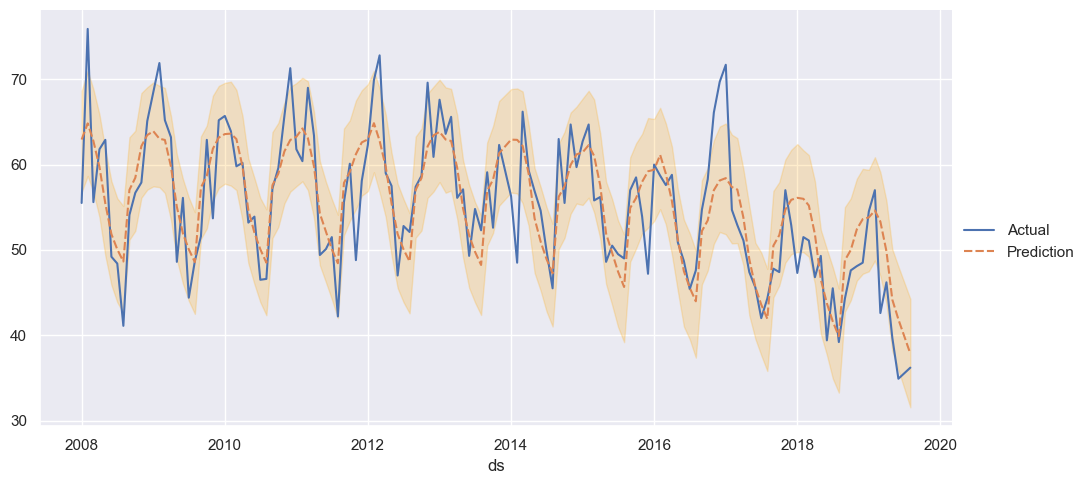

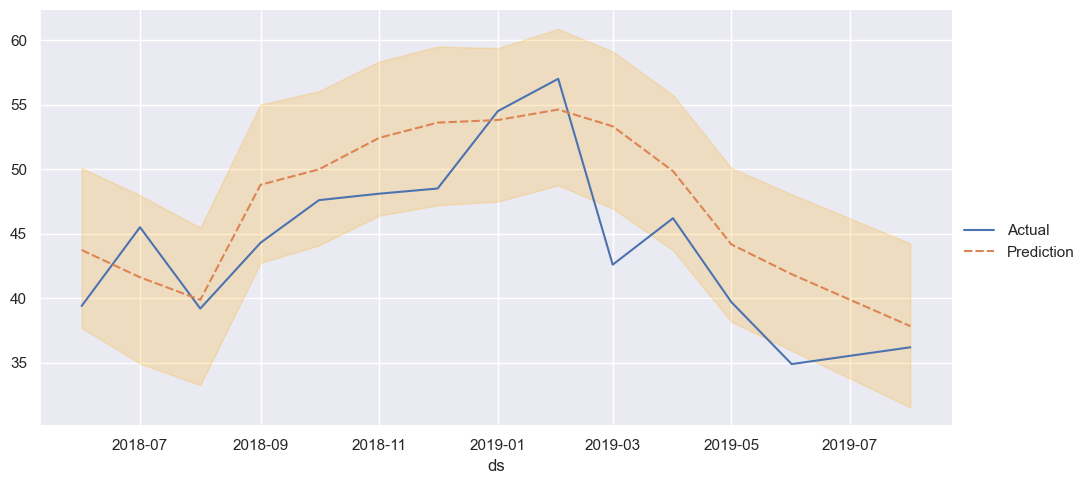

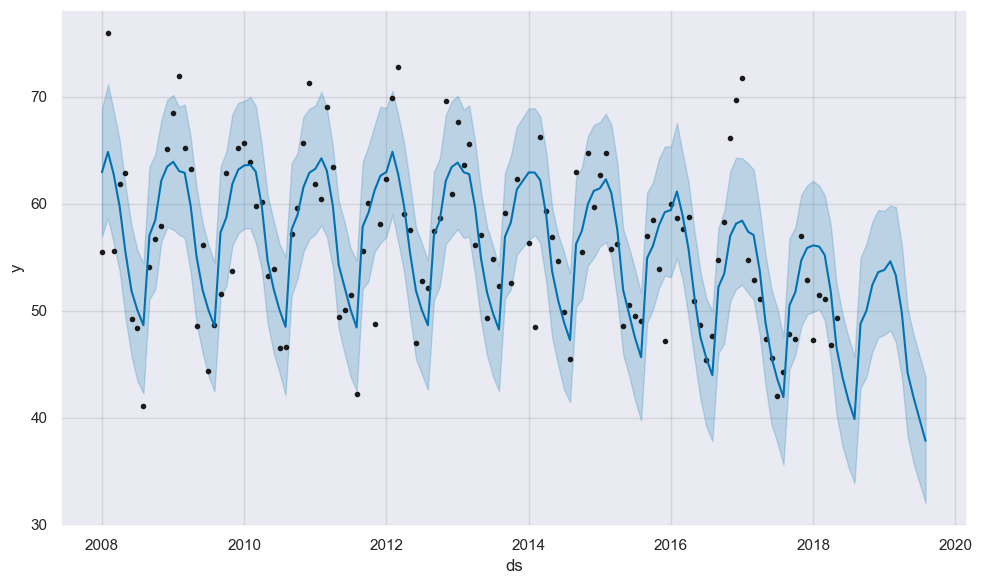

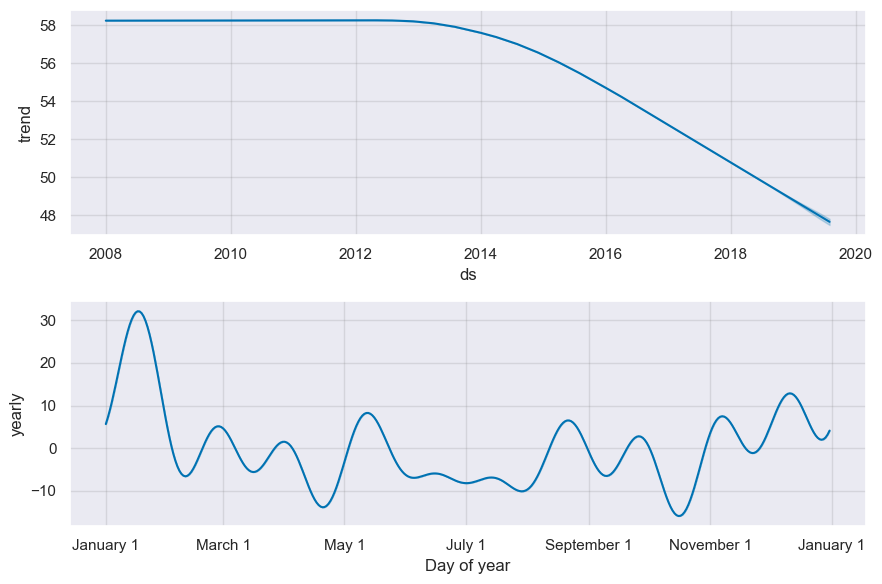

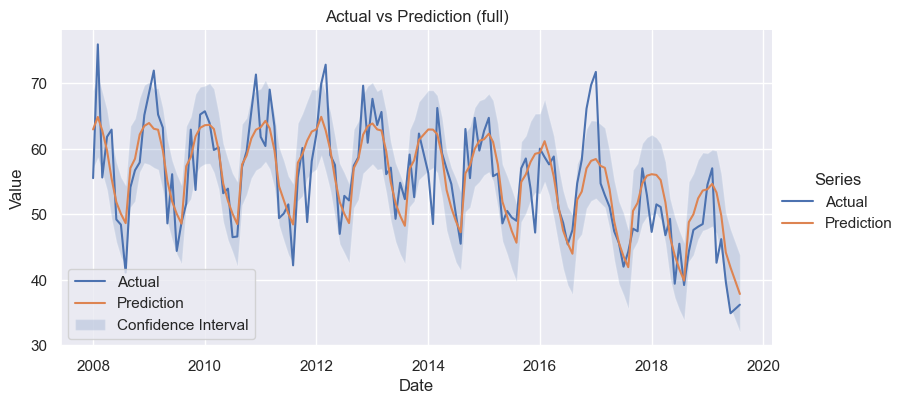

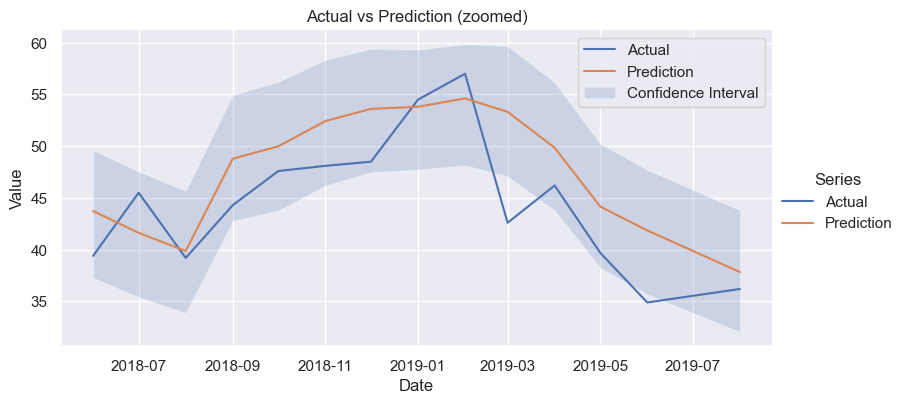

In [26]:
# --- Forecast ---
forecast: pd.DataFrame = model.predict(no2_df)

# --- Prophet built-in plots (force display) ---
fig1 = model.plot(forecast)
plt.show()

fig2 = model.plot_components(forecast)
plt.show()

# --- Prep actual vs prediction for Seaborn ---
plot_df = no2_df[['ds', 'y']].rename(columns={'y': 'Actual'}).set_index('ds')
plot_df['Prediction'] = forecast.set_index('ds')['yhat']  # align on index

# Long format is more reliable for seaborn.relplot
df_long = (
    plot_df
    .reset_index()
    .melt(id_vars='ds', var_name='Series', value_name='Value')
)

# --- FULL RANGE line plot ---
g_full = sns.relplot(
    data=df_long,
    kind='line',
    x='ds',
    y='Value',
    hue='Series',
    aspect=2,
    height=4
)
# Get an axes handle from the FacetGrid (compat for different seaborn versions)
ax_full = getattr(g_full, "ax", None)
if ax_full is None:
    ax_full = g_full.axes[0, 0]

# Confidence band (full range)
ax_full.fill_between(
    forecast['ds'],
    forecast['yhat_lower'],
    forecast['yhat_upper'],
    alpha=0.2,
    label='Confidence Interval'
)
ax_full.set_title("Actual vs Prediction (full)")
ax_full.set_xlabel("Date")
ax_full.set_ylabel("Value")
ax_full.legend()
plt.show()  # <-- force render

# --- ZOOMED plot ---
# idx_split must be defined (e.g., the index where you want to zoom from)
# Example: idx_split = plot_df.index.get_loc(pd.Timestamp("2024-01-01"))
df_long_zoom = df_long[df_long['ds'] >= plot_df.index[idx_split]]

g_zoomed = sns.relplot(
    data=df_long_zoom,
    kind='line',
    x='ds',
    y='Value',
    hue='Series',
    aspect=2,
    height=4
)
ax_zoomed = getattr(g_zoomed, "ax", None)
if ax_zoomed is None:
    ax_zoomed = g_zoomed.axes[0, 0]

fz = forecast[forecast['ds'] >= plot_df.index[idx_split]]
ax_zoomed.fill_between(
    fz['ds'],
    fz['yhat_lower'],
    fz['yhat_upper'],
    alpha=0.2,
    label='Confidence Interval'
)
ax_zoomed.set_title("Actual vs Prediction (zoomed)")
ax_zoomed.set_xlabel("Date")
ax_zoomed.set_ylabel("Value")
ax_zoomed.legend()
plt.show()  # <-- force render

In [27]:
future = model.make_future_dataframe(730)
forecast = model.predict(future)

/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


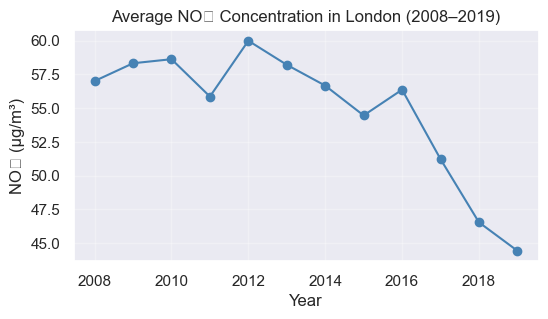

In [36]:
import matplotlib.pyplot as plt

summary = no2_df.copy()
summary['year'] = summary['ds'].dt.year
avg_by_year = summary.groupby('year')['y'].mean()

fig, ax = plt.subplots(figsize=(6,3))
ax.plot(avg_by_year.index, avg_by_year.values, marker='o', color='steelblue')
ax.set_title('Average NO₂ Concentration in London (2008–2019)')
ax.set_xlabel('Year')
ax.set_ylabel('NO₂ (µg/m³)')
ax.grid(True, alpha=0.3)
plt.show()

/var/folders/xn/tw0sz0nx6dv2wmn3xgpg0s0r0000gn/T/ipykernel_1093/2398685936.py:27: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout()
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


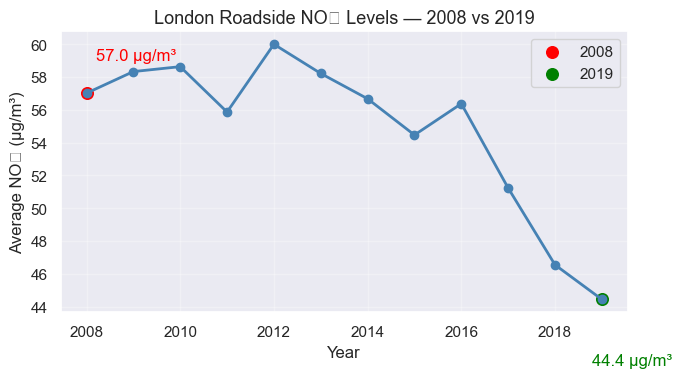

In [37]:
import matplotlib.pyplot as plt
import pandas as pd

# Prepare yearly averages
summary = no2_df.copy()
summary['year'] = summary['ds'].dt.year
avg_by_year = summary.groupby('year')['y'].mean().reset_index()

# Plot
fig, ax = plt.subplots(figsize=(7,4))
ax.plot(avg_by_year['year'], avg_by_year['y'], marker='o', linewidth=2, color='steelblue')

# Highlight first and last points
ax.scatter(avg_by_year['year'].iloc[0], avg_by_year['y'].iloc[0], color='red', s=70, label='2008')
ax.scatter(avg_by_year['year'].iloc[-1], avg_by_year['y'].iloc[-1], color='green', s=70, label='2019')

# Annotate change
ax.text(2008.2, avg_by_year['y'].iloc[0]+2, f"{avg_by_year['y'].iloc[0]:.1f} µg/m³", color='red')
ax.text(2018.8, avg_by_year['y'].iloc[-1]-4, f"{avg_by_year['y'].iloc[-1]:.1f} µg/m³", color='green')

# Title & labels
ax.set_title("London Roadside NO₂ Levels — 2008 vs 2019", fontsize=13)
ax.set_xlabel("Year")
ax.set_ylabel("Average NO₂ (µg/m³)")
ax.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()